In [1]:
import infofile 
import numpy as np 
import matplotlib.pyplot as plt 
import matplotlib_inline 
matplotlib_inline.backend_inline.set_matplotlib_formats('pdf', 'svg') 
from matplotlib.ticker import AutoMinorLocator # for minor ticks
import uproot 
import awkward as ak 
import vector 
import time
import pandas as pd 
import math 
import cProfile
import seaborn as sns
import pickle

# Data Preprocessing

In [2]:
path = "4lep"


MeV = 0.001
GeV = 1.0
lumi = 10 

fraction = 1 #changes how much of the data is going to be processed

weight_variables = ["mcWeight", "scaleFactor_PILEUP", "scaleFactor_ELE", "scaleFactor_MUON", "scaleFactor_LepTRIGGER"]

indices = [0,1,2,3]  # change to test amount of of lep pt included

#this is here so we can have easy acces into the root files that are of use to us
samples = {

    # 'data': {
    #     'list' : ['data_A','data_B','data_C','data_D']
    # },

    # r'Background $Z,t\bar{t}$' : { # Z + ttbar
    #     'list' : ['Zee','Zmumu','ttbar_lep'],
    #     'color' : "#6b59d3" # purple
    # },

    r'Background $ZZ^*$' : { # ZZ
        'list' : ['llll'],
        'color' : "#ff0000" # red
    },

    r'Signal ($m_H$ = 125 GeV)' : { # H -> ZZ -> llll
        'list' : ['ggH125_ZZ4lep','VBFH125_ZZ4lep','WH125_ZZ4lep','ZH125_ZZ4lep'],
        'color' : "#00cdff" # light blue
    },

}

In [3]:
def cut_lep_type(lep_type):
# for an electron 11
# for a muon 13
# possible scnearios: eeee(44) eemumu(48) mumumumu(52), cut rest
    sum_lep_type = lep_type[0] + lep_type[1] + lep_type[2] + lep_type[3]
    return (sum_lep_type != 44) & (sum_lep_type != 48) & (sum_lep_type != 52)


def cut_lep_charge(lep_charge):
# Higgs has no charge, according to conservation laws total charge has to be 0, cut rest
    return lep_charge[0] + lep_charge[1] + lep_charge[2] + lep_charge[3] != 0

def get_xsec_weight(sample):
    info = infofile.infos[sample]
    xsec_weight = (lumi*1000*info["xsec"])/(info["sumw"]*info["red_eff"])
    return xsec_weight

def calc_weight(xsec_weight, data, weight_vars):
    return xsec_weight * data[weight_vars].prod(axis=1)

def calc_lep_pt(lep_pt,i):
    return lep_pt[i]/1000 # /1000 to go from MeV to GeV

#invariant mass = sqrt(pow(total energy,2) - pow(total momentum,2))
def calc_mass(lep_pt, lep_eta, lep_phi, lep_E):
    p4 = vector.zip({"pt": lep_pt, "eta": lep_eta, "phi": lep_phi, "E": lep_E})
    mass_Z1 = (p4[:, 0] + p4[:, 1]).M * MeV # .M calculates the invariant mass
    mass_Z2 = (p4[:, 2] + p4[:, 3]).M * MeV
    invariant_mass = (p4[:, 0] + p4[:, 1] + p4[:, 2] + p4[:, 3]).M * MeV
    return mass_Z1, mass_Z2, invariant_mass

def process_lep_pt(data, indices):
    for index in indices:
        data[f'lep_pt_{index}'] = np.vectorize(calc_lep_pt)(data.lep_pt, index)
    return data

def process_lep_eta(data, indices):
    for index in indices:
        data[f'lep_eta_{index}'] = data['lep_eta'].apply(lambda x: x[index] if len(x) > index else None)
    return data

def process_lep_phi(data, indices):
    for index in indices:
        data[f'lep_phi_{index}'] = data['lep_phi'].apply(lambda x: x[index] if len(x) > index else None)
    return data

def process_lep_E(data, indices):
    for index in indices:
        data[f'lep_E_{index}'] = data['lep_E'].apply(lambda x: x[index] if len(x) > index else None)
    return data

#gives us a y for production channel and path 
def production_channel(path):
    path = path.lower()
    mapping = {
        'ggh': 0,
        'vbfh': 1,
        'wh': 2,
        'zh': 3
    }
    for key, val in mapping.items():
        if key in path:
            return val,1
    return -1,0  #background

In [4]:
def gatheringData():
    data = {}
    #iterate over the dictionary
    for s in samples:
        print(s)
        frames = []

        #iterate over the list inside said dictionary
        for val in samples[s]['list']:
            if s == 'data':
                prefix = '/Data/'
            else:
                #infofile i got from the ATLAS site so we have acces to a huge dictionary with stuff we are going to use
                # but most importantly so we can go through our data and select the data needed
                prefix = '/Mc/mc_' + str(infofile.infos[val]['DSID']) + '.'
            filePath = path + prefix + val + '.4lep.root'#set filepath
            temp = read_file(filePath,val)#read the file
            frames.append(temp)
        data[s] = pd.concat(frames)
    
    return data#return the data 


def read_file(path,sample):
    start = time.time()
    print(sample)

    p_channel,outcome = production_channel(path)

    all_data = pd.DataFrame()

    currentData = uproot.open(path)
    tree = currentData["mini;1"]#open tree

    if 'data' not in sample:
        xsec_weight = get_xsec_weight(sample)

    for data in tree.iterate(library="pd", entry_stop=tree.num_entries*fraction, step_size = 1000000):
        nIn = len(data.index)
        
        if 'data' not in sample: 
            # multiply all Monte Carlo weights and scale factors together to give total weight
            data['totalWeight'] = calc_weight(xsec_weight,data,weight_variables)
            
        data = data[~np.vectorize(cut_lep_type)(data['lep_type'])]
        
        data = data[~np.vectorize(cut_lep_charge)(data['lep_charge'])]

        # data = process_lep_pt(data, indices)
        # data = process_lep_eta(data,indices)
        # data = process_lep_phi(data, indices)
        # data = process_lep_E(data, indices)

        data['mZ1'],data['mZ2'],data['m4l'] = calc_mass(data['lep_pt'], data['lep_eta'], data['lep_phi'], data['lep_E'])

        data['Production Channel'],data['Outcome'] = p_channel,outcome

        #got some stuff from the ATLAS site for visualization
        nOut = len(data.index) # number of events passing cuts in this batch
        all_data = pd.concat([all_data, data], ignore_index=True) # append dataframe from this batch to the dataframe for the whole sample
        elapsed = time.time() - start # time taken to process
        print("\t\t nIn: "+str(nIn)+",\t nOut: \t"+str(nOut)+"\t in "+str(round(elapsed,1))+"s") # events before and after
    
    return all_data # return dataframe containing events passing all cuts



In [ ]:
start = time.time()
data = gatheringData()
finish = time.time() - start
print("Time taken: "+str(round(finish,1))+"s") # print total time taken to process every file

In [ ]:
# #Save the data
# with open("data.pkl", "wb") as f:
#     pickle.dump(data, f)

In [5]:
# Load the saved data
with open("data.pkl", "rb") as f:
    data = pickle.load(f)

# Now you can use the `data` object as needed
print(data)


{'Background $ZZ^*$':         runNumber  eventNumber  channelNumber  mcWeight  scaleFactor_PILEUP  \
0          284500         4241         363490  0.126207            1.745631   
1          284500          491         363490  0.332061            0.187531   
2          284500         3889         363490  1.000000            1.241677   
3          284500         4151         363490  1.000000            0.934886   
4          284500         4784         363490  0.127306            0.923924   
...           ...          ...            ...       ...                 ...   
523952     284500     16814810         363490  0.299751            1.214122   
523953     284500     16814112         363490  0.140462            1.251332   
523954     284500     16814080         363490  1.000000            1.320948   
523955     284500     16814835         363490  1.000000            1.320948   
523956     284500     16814286         363490  0.110684            1.251332   

        scaleFactor_ELE  scal

In [ ]:
print(data.keys())

df_background = data["Background $ZZ^*$"]
print(type(df_background))
print(df_background.shape)
df_signal = data["Signal ($m_H$ = 125 GeV)"]
print(type(df_signal))
print(df_signal.shape)

In [6]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.utils import shuffle
import dask.dataframe as dd
from sklearn.ensemble import RandomForestClassifier  # or Regressor

In [ ]:


# Concatenate the dataframes
df_combined = pd.concat([df_signal, df_background])

# Shuffle the dataframe
df_combined = shuffle(df_combined, random_state=42)  # Set random_state for reproducibility

# Now df_combined contains both signal and background data with the outcome column


In [ ]:
# with open("dfcombined.pkl", "wb") as f:
#     pickle.dump(df_combined, f)

In [7]:
with open("dfcombined.pkl", "rb") as f:
    df_combined = pickle.load(f)

In [ ]:
X = df_combined.drop(['Outcome','Production Channel','runNumber', 'eventNumber', 'channelNumber', 'mcWeight',
       'scaleFactor_PILEUP', 'scaleFactor_ELE', 'scaleFactor_MUON',
       'scaleFactor_PHOTON', 'scaleFactor_TAU', 'scaleFactor_BTAG',
       'scaleFactor_LepTRIGGER', 'scaleFactor_PhotonTRIGGER','XSection','SumWeights','totalWeight','trigE', 'trigM','trigP' ,'lep_n'], axis='columns')
y = df_combined[['Outcome','Production Channel']]

In [ ]:
print(X.info())
print(y.info())

In [ ]:
def is_awkward_array(series):
    if len(series) > 0:
        return isinstance(series.iloc[0], ak.Array)
    else:
        return False

In [ ]:
def flatten_awkward_column(df, column_name, max_particles=4):
    filled = ak.pad_none(df[column_name], max_particles)
    
    # Create dictionary of new columns
    new_columns = {}
    for i in range(max_particles):
        new_columns[f"{column_name}_{i}"] = ak.to_numpy(filled[:, i])
    
    # Remove original column and add all new columns at once
    result_df = df.drop(columns=[column_name])
    return pd.concat([result_df, pd.DataFrame(new_columns, index=df.index)], axis=1)


# for col in ["lep_pt", "lep_eta", "lep_phi", "jet_pt", "jet_eta", "jet_phi","photon_pt", "photon_eta", "photon_phi", "tau_pt", "tau_eta", "tau_phi","largeRjet_pt", "largeRjet_eta", "largeRjet_phi",]:
#     if col in X.columns:
#         X = flatten_awkward_column(X, col, max_particles=4)

for col in X.columns:
    
    # Check if the column contains awkward arrays before flattening
    if is_awkward_array(X[col]):
        print(col)
        X = flatten_awkward_column(X, col, max_particles=4)

In [ ]:
# with open("X.pkl", "wb") as f:
#     pickle.dump(X, f)

# with open("y.pkl", "wb") as f:
#     pickle.dump(y, f)
# # print("Time taken: "+str(round(finish,1))+"s")

In [8]:
import pickle
# Load the saved data
with open("X.pkl", "rb") as f:
    X = pickle.load(f)
with open("y.pkl", "rb") as f:
    y = pickle.load(f)

In [9]:
X = X.select_dtypes(exclude=["object"])


In [10]:
X = X.dropna(axis=1, how='all')


In [11]:
X.fillna(-999, inplace=True)


In [12]:
# build mask columns 
mask_cols = {
    f"has_jet_{i}": (X[f"jet_pt_{i}"] != -999).astype(int)
    for i in range(4) if f"jet_pt_{i}" in X.columns
}


X = pd.concat([X, pd.DataFrame(mask_cols, index=X.index)], axis=1)

# Defragment =
X = X.copy()


In [13]:
XforSHAP = X

In [14]:
y = y['Outcome']

In [15]:
print(X.info(verbose=True, show_counts=True))


<class 'pandas.core.frame.DataFrame'>
Index: 893997 entries, 421721 to 121958
Data columns (total 107 columns):
 #    Column                      Non-Null Count   Dtype  
---   ------                      --------------   -----  
 0    met_et                      893997 non-null  float32
 1    met_phi                     893997 non-null  float32
 2    jet_n                       893997 non-null  uint32 
 3    photon_n                    893997 non-null  uint32 
 4    tau_n                       893997 non-null  uint32 
 5    ditau_m                     893997 non-null  float32
 6    met_et_syst                 893997 non-null  float32
 7    largeRjet_n                 893997 non-null  uint32 
 8    mZ1                         893997 non-null  float64
 9    mZ2                         893997 non-null  float64
 10   m4l                         893997 non-null  float64
 11   lep_truthMatched_0          893997 non-null  bool   
 12   lep_truthMatched_1          893997 non-null  bool   
 13

In [16]:
X_SHAPStrain, X_SHAPtest, _,_ = train_test_split(XforSHAP, y,
                                                  test_size=0.15,  
                                                  random_state=492)  

# ML Model Start

In [17]:
from sklearn.model_selection import train_test_split


X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, 
                                                  test_size=0.15,  
                                                  random_state=492)  


X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, 
                                                  test_size=0.15,  
                                                  random_state=42) 

In [18]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler() 

scaler.fit(X_train)

#scale test val and train data
X_train_scaled = scaler.transform(X_train)  
X_val_scaled = scaler.transform(X_val)     
X_test_scaled = scaler.transform(X_test)   

In [ ]:
# X_test_csv = pd.DataFrame(X_test_scaled)

# X_test_csv.to_csv('output_data_scaled_new.csv', index=False)

In [ ]:
# column_names = X_test.columns  

# X_test_csv = pd.DataFrame(X_test_scaled, columns=column_names)

# X_test_csv['Outcome'] = y_test.values 

# X_test_csv.to_csv('output_data_scaled_with_outcome.csv', index=False)

In [19]:
print("Any NaNs in X_train_scaled?", np.isnan(X_train_scaled).any())
print("Any NaNs in y_train?", np.isnan(y).any())


Any NaNs in X_train_scaled? False
Any NaNs in y_train? False


In [20]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt
import joblib
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix
import shap

c:\Users\bora-\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [21]:
X_train_np = X_train_scaled.astype(np.float32)  
X_val_np = X_val_scaled.astype(np.float32)
X_test_np = X_test_scaled.astype(np.float32)

y_train_np = y_train.to_numpy(dtype=np.int64)  
y_val_np = y_val.to_numpy(dtype=np.int64)
y_test_np = y_test.to_numpy(dtype=np.int64)

# convert to tensors
X_train_tensor = torch.tensor(X_train_np)
y_train_tensor = torch.tensor(y_train_np)

X_val_tensor = torch.tensor(X_val_np)
y_val_tensor = torch.tensor(y_val_np)

X_test_tensor = torch.tensor(X_test_np)
y_test_tensor = torch.tensor(y_test_np)


In [22]:
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
# test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

#adjust batchsize as needed
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
# test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [23]:
class MLP(nn.Module):
    def __init__(self, input_size, hidden_layers, num_classes,dropout_rate=0.3):
        super(MLP, self).__init__()
        layers = []
        prev_size = input_size
        
        for hidden_size in hidden_layers:
            layers.append(nn.Linear(prev_size, hidden_size))
            layers.append(nn.BatchNorm1d(hidden_size))  # batchnorm to stabilize training 
            layers.append(nn.LeakyReLU(negative_slope=0.01))
            prev_size = hidden_size
            layers.append(nn.Dropout(dropout_rate))
            
        
        layers.append(nn.Linear(prev_size, num_classes))  # output layer
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

In [24]:
# initialize model
input_size = X_train.shape[1]  # no of features
hidden_layers = [512, 256, 128, 64] 
num_classes = len(np.unique(y_train))  # no of classes

mlp = MLP(input_size, hidden_layers, num_classes)

In [25]:
# move to GPU 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
mlp.to(device)

MLP(
  (model): Sequential(
    (0): Linear(in_features=107, out_features=512, bias=True)
    (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Dropout(p=0.3, inplace=False)
    (4): Linear(in_features=512, out_features=256, bias=True)
    (5): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): LeakyReLU(negative_slope=0.01)
    (7): Dropout(p=0.3, inplace=False)
    (8): Linear(in_features=256, out_features=128, bias=True)
    (9): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.01)
    (11): Dropout(p=0.3, inplace=False)
    (12): Linear(in_features=128, out_features=64, bias=True)
    (13): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): LeakyReLU(negative_slope=0.01)
    (15): Dropout(p=0.3, inplace=False)
    (16): Linear(in_features=64, out_feature

In [26]:
import torch.nn.functional as F

class FocalLoss(nn.Module):
    def __init__(self, alpha=None, gamma=2, reduce=True):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduce = reduce

    def forward(self, inputs, targets):
        log_probs = F.log_softmax(inputs, dim=1)
        
        log_p_t = log_probs.gather(1, targets.unsqueeze(1)).squeeze(1)
        
        p_t = log_p_t.exp()

        if self.alpha is not None:
            alpha_t = self.alpha[targets]
        else:
            alpha_t = 1.0
        
        loss = -alpha_t * (1 - p_t) ** self.gamma * log_p_t
        
        if self.reduce:
            return loss.mean()
        else:
            return loss

# weight ratio same 
class_counts = torch.tensor([280798, 198383], dtype=torch.float32)
class_weights = class_counts.sum() / (len(class_counts) * class_counts)
alpha = class_weights.to(device)

criterion = FocalLoss(alpha=alpha, gamma=2)

In [27]:
optimizer = optim.Adam(mlp.parameters(), lr=0.0001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)

# Cross validation

In [ ]:
from sklearn.model_selection import StratifiedKFold
import numpy as np

k_folds = 5
skf = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=42)

X_np = X.values.astype(np.float32)
y_np = y.values.astype(np.int64)


fold_results = []

for fold, (train_idx, val_idx) in enumerate(skf.split(X_np, y_np)):
    if fold < 1:
        continue
    print(f"\n--- Fold {fold+1}/{k_folds} ---")

    # create dataset for this fold 
    X_train_fold, y_train_fold = X_np[train_idx], y_np[train_idx]
    X_val_fold, y_val_fold = X_np[val_idx], y_np[val_idx]

    # convert 
    train_dataset = TensorDataset(torch.tensor(X_train_fold, dtype=torch.float32),
                                  torch.tensor(y_train_fold, dtype=torch.long))
    val_dataset = TensorDataset(torch.tensor(X_val_fold, dtype=torch.float32),
                                torch.tensor(y_val_fold, dtype=torch.long))

    train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)

    # Initialize everything
    mlp = MLP(input_size, hidden_layers, num_classes)
    mlp.to(device)
    optimizer = torch.optim.Adam(mlp.parameters(), lr=0.001)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5)
    criterion = FocalLoss(alpha=alpha, gamma=2)

    # bscially training loop
    best_val_loss = float("inf")
    no_improve_count = 0
    patience = 20
    num_epochs = 150

    for epoch in range(num_epochs):
        mlp.train()
        running_loss = 0.0
        all_preds, all_labels = [], []

        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            outputs = mlp(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(mlp.parameters(), max_norm=1.0)
            optimizer.step()

            running_loss += loss.item()
            preds = torch.argmax(outputs, dim=1).cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(y_batch.cpu().numpy())

        train_acc = accuracy_score(all_labels, all_preds)

        mlp.eval()
        val_loss = 0.0
        val_preds, val_labels = [], []

        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                outputs = mlp(X_batch)
                loss = criterion(outputs, y_batch)
                val_loss += loss.item()
                preds = torch.argmax(outputs, dim=1).cpu().numpy()
                val_preds.extend(preds)
                val_labels.extend(y_batch.cpu().numpy())

        avg_val_loss = val_loss / len(val_loader)
        val_acc = accuracy_score(val_labels, val_preds)
        val_prec = precision_score(val_labels, val_preds, zero_division=1)
        val_rec = recall_score(val_labels, val_preds, zero_division=1)
        val_f1 = f1_score(val_labels, val_preds, zero_division=1)

        print(f"Epoch {epoch+1} - Val Loss: {avg_val_loss:.4f} - Acc: {val_acc:.4f} - F1: {val_f1:.4f}")

        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            scheduler.step(avg_val_loss)
            no_improve_count = 0
        else:
            no_improve_count += 1
            if no_improve_count >= patience:
                print("Early stopping")
                break

    fold_results.append({
        "fold": fold + 1,
        "val_acc": val_acc,
        "val_prec": val_prec,
        "val_rec": val_rec,
        "val_f1": val_f1
    })

# After all folds
print("\n=== Cross-Validation Results ===")
for result in fold_results:
    print(f"Fold {result['fold']} - Acc: {result['val_acc']:.4f}, Prec: {result['val_prec']:.4f}, Rec: {result['val_rec']:.4f}, F1: {result['val_f1']:.4f}")

# Optionally, average metrics across all folds
avg_f1 = np.mean([r["val_f1"] for r in fold_results])
print(f"\nAverage F1 over {k_folds} folds: {avg_f1:.4f}")


In [ ]:
fold_results.insert(0, {
    "fold": 1,
    "val_acc": 0.9518,
    "val_prec": 0.9434,
    "val_rec": 0.9399,
    "val_f1": 0.9416
})


In [ ]:
# After all folds
print("\n=== Cross-Validation Results ===")
for result in fold_results:
    print(f"Fold {result['fold']} - Acc: {result['val_acc']:.4f}, Prec: {result['val_prec']:.4f}, Rec: {result['val_rec']:.4f}, F1: {result['val_f1']:.4f}")

In [ ]:
import numpy as np

val_accuracies = [0.9518, 0.9658, 0.9686, 0.9629, 0.9654]
val_precisions = [0.9434, 0.9405, 0.9474, 0.9358, 0.9368]
val_recalls = [0.9399, 0.9794, 0.9786, 0.9775, 0.9828]
val_f1s = [0.9416, 0.9596, 0.9627, 0.9562, 0.9593]

print("=== Average Performance Across Folds ===")
print(f"Accuracy:  {np.mean(val_accuracies):.4f} ± {np.std(val_accuracies):.4f}")
print(f"Precision: {np.mean(val_precisions):.4f} ± {np.std(val_precisions):.4f}")
print(f"Recall:    {np.mean(val_recalls):.4f} ± {np.std(val_recalls):.4f}")
print(f"F1 Score:  {np.mean(val_f1s):.4f} ± {np.std(val_f1s):.4f}")


=== Cross-Validation Results ===
Fold 1 - Acc: 0.9518, Prec: 0.9434, Rec: 0.9399, F1: 0.9416

# Training Loop

In [ ]:

losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

best_val_loss = float("inf")
patience = 20
no_improve_count = 0

num_epochs = 150

#training
for epoch in range(num_epochs):
    mlp.train()
    running_loss = 0.0
    all_preds, all_labels = [], []

    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        outputs = mlp(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(mlp.parameters(), max_norm=1.0)

        optimizer.step()

        running_loss += loss.item()

        preds = torch.argmax(outputs, dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(y_batch.cpu().numpy())

    avg_train_loss = running_loss / len(train_loader)
    losses.append(avg_train_loss)

    train_acc = accuracy_score(all_labels, all_preds)
    train_accuracies.append(train_acc)

    #validation phase
    mlp.eval()
    val_loss = 0.0
    all_val_preds, all_val_labels = [], []

    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            outputs = mlp(X_batch)
            loss = criterion(outputs, y_batch)
            val_loss += loss.item()

            preds = torch.argmax(outputs, dim=1).cpu().numpy()
            all_val_preds.extend(preds)
            all_val_labels.extend(y_batch.cpu().numpy())


    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    val_acc = accuracy_score(all_val_labels, all_val_preds)
    val_prec = precision_score(all_val_labels, all_val_preds, zero_division=1)
    val_rec = recall_score(all_val_labels, all_val_preds, zero_division=1)
    val_f1 = f1_score(all_val_labels, all_val_preds, zero_division=1)


    print(f"Epoch {epoch+1}/{num_epochs} - "
          f"Loss: {avg_train_loss:.4f} - Val Loss: {avg_val_loss:.4f} - "
          f"Acc: {val_acc:.4f} - Prec: {val_prec:.4f} - Rec: {val_rec:.4f} - F1: {val_f1:.4f}")


    # early stopping to stop overfitting
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        scheduler.step(avg_val_loss)
        torch.save(mlp.state_dict(), "SKY2FINALFINALFINALfurthertesting.pth")
        no_improve_count = 0  
    else:
        no_improve_count += 1
        print(no_improve_count)
        if no_improve_count >= patience:
            print(f"Early stopping triggered at epoch {epoch+1}")
            break


plt.plot(losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss Curve")
plt.legend()


In [28]:
print(f"Model device: {next(mlp.parameters()).device}")
print(f"X_test_tensor device: {X_test_tensor.device}")
# print(f"y_test_tensor device: {y_test_tensor.device}")


Model device: cuda:0
X_test_tensor device: cpu


In [29]:
# Move test data to the same device as the model
X_test_tensor = X_test_tensor.to("cuda")
# y_test_tensor = y_test_tensor.to("cuda")


In [ ]:
# mlp.load_state_dict(torch.load("SKY2FINALFINALFINAL.pth", map_location=device))

In [30]:
mlp.load_state_dict(torch.load("SKY2FINALFINALFINALfurthertesting.pth", map_location=device))

<All keys matched successfully>

In [33]:
features_names = list(X.columns)

In [34]:
print(len(features_names))

107


In [ ]:
# mlp.eval()  # Set to evaluation mode

# # 2. Now save the model with all the metadata needed for deployment
# torch.save({
#     'model_state_dict': mlp.state_dict(),
#     'input_features': features_names,  # List of feature names you used for training
#     'normalization_params': {
#         'mean': scaler.mean_,  # Mean values from your StandardScaler
#         'std': scaler.scale_   # Standard deviation values from your StandardScaler
#     }
# }, "SKY2FinalFinalFinalForRealThisOne.pth")

# Eval Function

In [31]:
def evaluate_model(model, data_tensor, labels_tensor, threshold=0.5):
    model.eval()
    
    with torch.no_grad():
        # get output
        outputs = model(data_tensor)

        probabilities = torch.softmax(outputs, dim=1)[:, 1] 

        
        # threshold aplication
        predicted = (probabilities >= threshold).int().cpu().numpy()
        true_labels = labels_tensor.cpu().numpy()
        
        # metrics
        acc = accuracy_score(true_labels, predicted)
        prec = precision_score(true_labels, predicted, zero_division=1)
        rec = recall_score(true_labels, predicted, zero_division=1)
        f1 = f1_score(true_labels, predicted, zero_division=1)
        
        # confusion matrix
        tn, fp, fn, tp = confusion_matrix(true_labels, predicted).ravel()
        cm = confusion_matrix(true_labels, predicted)

        # plot
        plt.figure(figsize=(6, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Background', 'Signal'], yticklabels=['Background', 'Signal'])
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.title('Confusion Matrix')
        plt.show()
        
        # s = tp  # signal = true positives
        # b = fp  # background = false positives
        
        # # Avoid division by zero with a small epsilon
        # epsilon = 1e-10
        # if b == 0:
        #     b = epsilon
            
        # ams = np.sqrt(2 * ((s + b) * np.log(1 + s/b) - s))
        
        # return all metrics
        return {
            'accuracy': acc,
            'precision': prec,
            'recall': rec,
            'f1_score': f1,
            'true_positives': tp,
            'false_positives': fp,
            'true_negatives': tn,
            'false_negatives': fn,
            # 'ams': ams,
            'confusion_matrix': np.array([[tn, fp], [fn, tp]])
        }


# Eval on balanced dataset

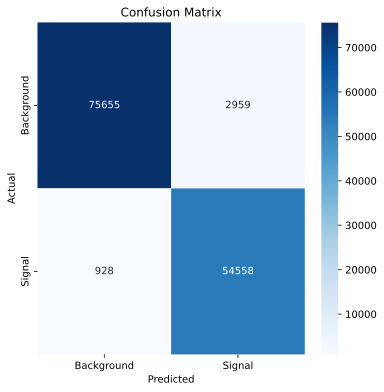


=== Threshold: 0.50 ===
Test Accuracy: 0.9710
Test Precision: 0.9486
Test Recall: 0.9833
Test F1 Score: 0.9656
Confusion Matrix:
[[75655  2959]
 [  928 54558]]


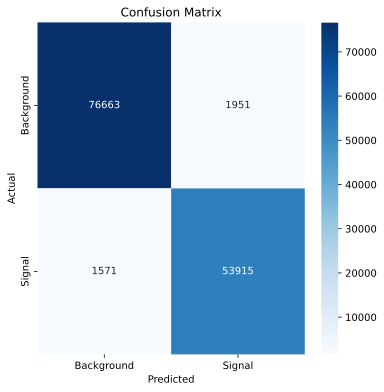


=== Threshold: 0.60 ===
Test Accuracy: 0.9737
Test Precision: 0.9651
Test Recall: 0.9717
Test F1 Score: 0.9684
Confusion Matrix:
[[76663  1951]
 [ 1571 53915]]


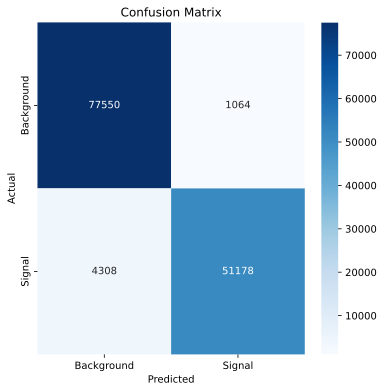


=== Threshold: 0.70 ===
Test Accuracy: 0.9599
Test Precision: 0.9796
Test Recall: 0.9224
Test F1 Score: 0.9501
Confusion Matrix:
[[77550  1064]
 [ 4308 51178]]


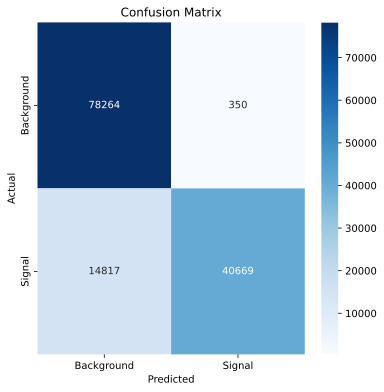


=== Threshold: 0.80 ===
Test Accuracy: 0.8869
Test Precision: 0.9915
Test Recall: 0.7330
Test F1 Score: 0.8428
Confusion Matrix:
[[78264   350]
 [14817 40669]]


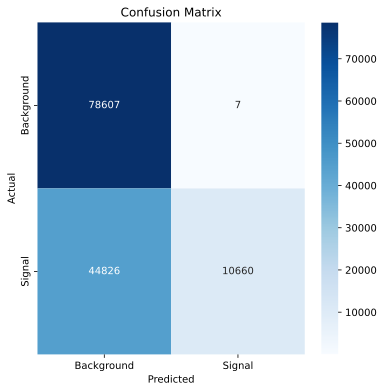


=== Threshold: 0.90 ===
Test Accuracy: 0.6657
Test Precision: 0.9993
Test Recall: 0.1921
Test F1 Score: 0.3223
Confusion Matrix:
[[78607     7]
 [44826 10660]]


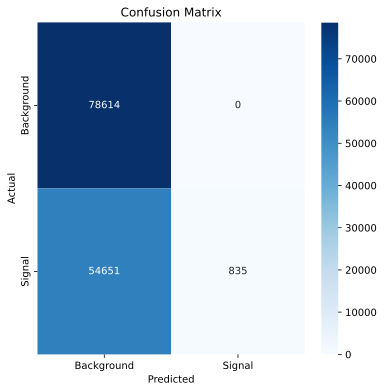


=== Threshold: 0.95 ===
Test Accuracy: 0.5925
Test Precision: 1.0000
Test Recall: 0.0150
Test F1 Score: 0.0297
Confusion Matrix:
[[78614     0]
 [54651   835]]


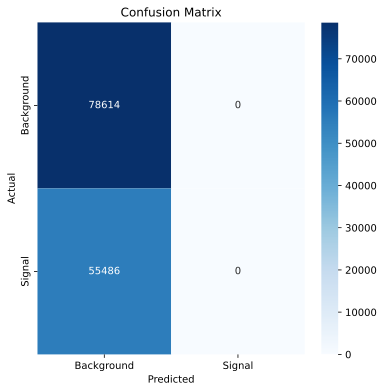


=== Threshold: 0.99 ===
Test Accuracy: 0.5862
Test Precision: 1.0000
Test Recall: 0.0000
Test F1 Score: 0.0000
Confusion Matrix:
[[78614     0]
 [55486     0]]


In [32]:
mlp.eval()

thresholds = [0.5,0.6,0.7,0.8, 0.9, 0.95, 0.99]
results = {}

for thresh in thresholds:
    metrics = evaluate_model(mlp, X_test_tensor, y_test_tensor, threshold=thresh)
    results[thresh] = metrics
    
    print(f"\n=== Threshold: {thresh:.2f} ===")
    print(f"Test Accuracy: {metrics['accuracy']:.4f}")
    print(f"Test Precision: {metrics['precision']:.4f}")
    print(f"Test Recall: {metrics['recall']:.4f}")
    print(f"Test F1 Score: {metrics['f1_score']:.4f}")
    # print(f"AMS Score: {metrics['ams']:.4f}")
    print(f"Confusion Matrix:\n{metrics['confusion_matrix']}")

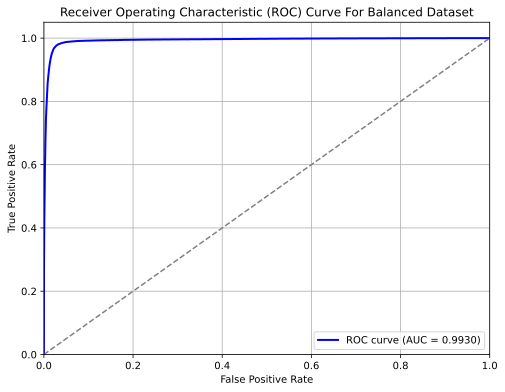

In [33]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# set model to eval
mlp.eval()

with torch.no_grad():
    # get prob
    y_probs = torch.softmax(mlp(X_test_tensor.to("cuda")), dim=1)[:, 1].cpu().numpy()

# roc
fpr, tpr, _ = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)

# plot
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--') 
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve For Balanced Dataset')
plt.legend(loc='lower right')
plt.grid()
plt.show()

# Eval on dataset that reflects physical Reality

In [34]:
signal_to_background_ratio = 1/100


signal_data = X_test_np[y_test == 1]
background_data = X_test_np[y_test == 0]

# ratio
num_background = len(background_data)
num_signal = int(num_background * signal_to_background_ratio)

if num_signal > len(signal_data):
    raise ValueError("Not enough signal data to meet the desired ratio.")

selected_signal_indices = np.random.choice(len(signal_data), size=num_signal, replace=False)
signal_data_sampled = signal_data[selected_signal_indices]
background_data = background_data

signal_labels = np.ones(num_signal, dtype=np.int64)
background_labels = np.zeros(num_background, dtype=np.int64)

realistic_data = np.concatenate([signal_data_sampled, background_data], axis=0)
realistic_labels = np.concatenate([signal_labels, background_labels], axis=0)

indices = np.random.permutation(len(realistic_data))
realistic_data = realistic_data[indices]
realistic_labels = realistic_labels[indices]

realistic_data_tensor = torch.tensor(realistic_data, dtype=torch.float32)
realistic_labels_tensor = torch.tensor(realistic_labels, dtype=torch.long)

# check
print("Data shape:", realistic_data_tensor.shape)
print("Label distribution:", dict(zip(*np.unique(realistic_labels, return_counts=True))))



Data shape: torch.Size([79400, 107])
Label distribution: {0: 78614, 1: 786}


In [39]:
realistic_data_tensor = realistic_data_tensor.to("cuda")
realistic_labels_tensor = realistic_labels_tensor.to("cuda")


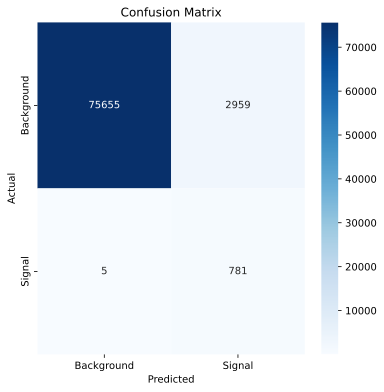


=== Threshold: 0.50 ===
Test Accuracy: 0.9627
Test Precision: 0.2088
Test Recall: 0.9936
Test F1 Score: 0.3451
Confusion Matrix:
[[75655  2959]
 [    5   781]]


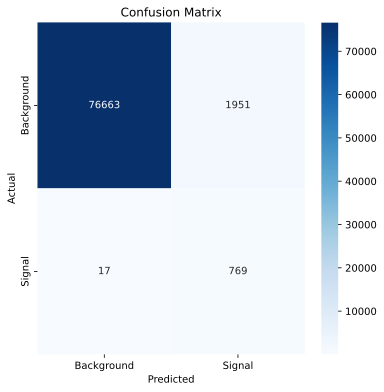


=== Threshold: 0.60 ===
Test Accuracy: 0.9752
Test Precision: 0.2827
Test Recall: 0.9784
Test F1 Score: 0.4387
Confusion Matrix:
[[76663  1951]
 [   17   769]]


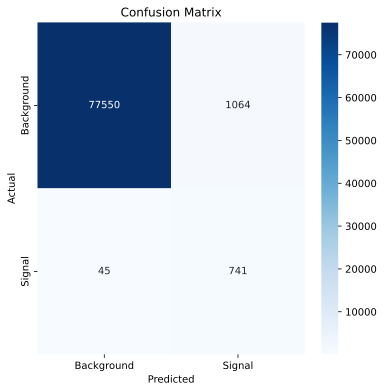


=== Threshold: 0.70 ===
Test Accuracy: 0.9860
Test Precision: 0.4105
Test Recall: 0.9427
Test F1 Score: 0.5720
Confusion Matrix:
[[77550  1064]
 [   45   741]]


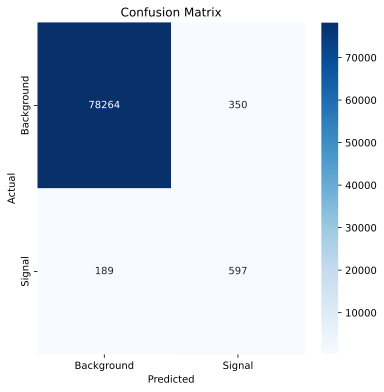


=== Threshold: 0.80 ===
Test Accuracy: 0.9932
Test Precision: 0.6304
Test Recall: 0.7595
Test F1 Score: 0.6890
Confusion Matrix:
[[78264   350]
 [  189   597]]


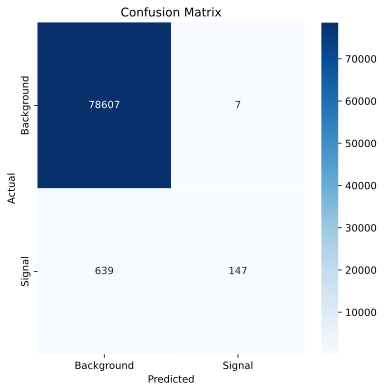


=== Threshold: 0.90 ===
Test Accuracy: 0.9919
Test Precision: 0.9545
Test Recall: 0.1870
Test F1 Score: 0.3128
Confusion Matrix:
[[78607     7]
 [  639   147]]


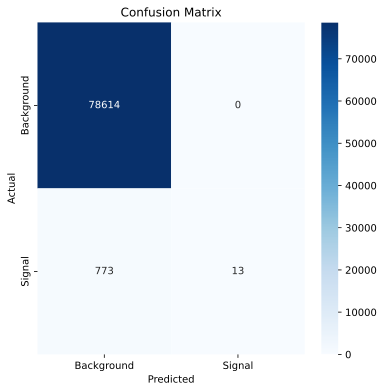


=== Threshold: 0.95 ===
Test Accuracy: 0.9903
Test Precision: 1.0000
Test Recall: 0.0165
Test F1 Score: 0.0325
Confusion Matrix:
[[78614     0]
 [  773    13]]


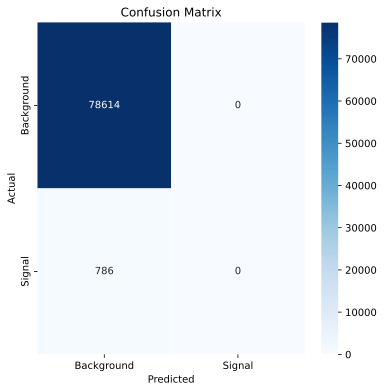


=== Threshold: 0.99 ===
Test Accuracy: 0.9901
Test Precision: 1.0000
Test Recall: 0.0000
Test F1 Score: 0.0000
Confusion Matrix:
[[78614     0]
 [  786     0]]


In [36]:
thresholds = [0.5,0.6,0.7,0.8, 0.9, 0.95, 0.99]
results = {}

for thresh in thresholds:
    metrics = evaluate_model(mlp, realistic_data_tensor, realistic_labels_tensor, threshold=thresh)
    results[thresh] = metrics
    
    print(f"\n=== Threshold: {thresh:.2f} ===")
    print(f"Test Accuracy: {metrics['accuracy']:.4f}")
    print(f"Test Precision: {metrics['precision']:.4f}")
    print(f"Test Recall: {metrics['recall']:.4f}")
    print(f"Test F1 Score: {metrics['f1_score']:.4f}")
    # print(f"AMS Score: {metrics['ams']:.4f}")
    print(f"Confusion Matrix:\n{metrics['confusion_matrix']}")

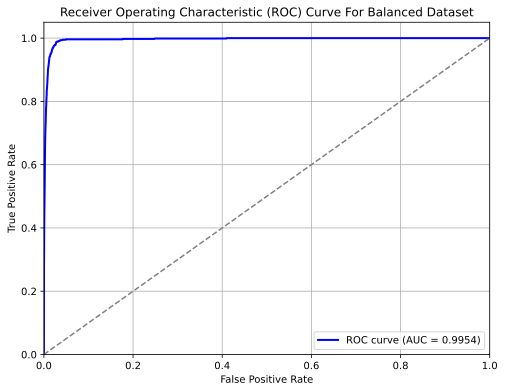

In [43]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

realistic_labels_tensor_numpy = realistic_labels_tensor.cpu().numpy()

# set model to eval
mlp.eval()

with torch.no_grad():
    # get prob
    y_probs = torch.softmax(mlp(realistic_data_tensor.to("cuda")), dim=1)[:, 1].cpu().numpy()

# roc
fpr, tpr, _ = roc_curve(realistic_labels_tensor_numpy, y_probs)
roc_auc = auc(fpr, tpr)

# plot
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--') 
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve For Balanced Dataset')
plt.legend(loc='lower right')
plt.grid()
plt.show()

# Interpretability with SHAP

In [ ]:
class WrappedModel:
    def __init__(self, model):
        self.model = model.eval()
        
    def predict(self, data_numpy):
        data_tensor = torch.tensor(data_numpy, dtype=torch.float32).to(device)
        with torch.no_grad():
            logits = self.model(data_tensor)
            probs = torch.nn.functional.softmax(logits, dim=1)
        return probs[:, 1].cpu().numpy() 


In [ ]:
background = X_train_np[np.random.choice(X_train_np.shape[0], 1000, replace=False)]
explainer = shap.Explainer(WrappedModel(mlp).predict, background)

In [ ]:
shap_values = explainer(X_test_np[:1000]) 

In [ ]:
print(df_combined['m4l'].describe())
print()
print(df_combined['mZ1'].describe())
print()
print(df_combined['mZ2'].describe())
print()
print(X['lep_pt_0'].describe())



In [ ]:

shap.summary_plot(shap_values, X_test[:1000], feature_names=X_val.columns.tolist())


In [ ]:
df_train = pd.DataFrame(X_train_np, columns=X_val.columns)

corr_matrix = df_train.corr()

# plot heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=False, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Feature Correlation Heatmap")
plt.show()


In [ ]:
pd.set_option("display.max_rows", None) 
corr_with_x = corr_matrix["m4l"].sort_values(ascending=False)
print(corr_with_x)

In [ ]:
pred_probs = mlp(torch.tensor(X_test_np[:5], dtype=torch.float32).to(device))
pred_labels = torch.argmax(pred_probs, dim=1).cpu().numpy()

# get original values
X_test_original = scaler.inverse_transform(X_test_np)

for i in range(5):
    true_label = y_test.iloc[i]
    predicted_label = pred_labels[i]
    
    actual_str = "Signal" if true_label == 1 else "Background"
    predicted_str = "Signal" if predicted_label == 1 else "Background"

    feature_contributions = shap_values.values[i]
    
    explanation = shap.Explanation(
        values=feature_contributions,
        base_values=shap_values.base_values[i],
        data=X_test_original[i],  # Use original unscaled values
        feature_names=X_val.columns.tolist()
    )

    plt.figure(figsize=(10, 6))
    plt.title(f"Example {i+1}: True={actual_str}, Predicted={predicted_str}")
    shap.plots.waterfall(explanation)

In [ ]:

m4l_idx = X_val.columns.get_loc("m4l")  

m4l_shap_values = shap_values.values[:, m4l_idx]  


m4l_values = X_test_np[:1000, m4l_idx]  

plt.scatter(m4l_values, m4l_shap_values, alpha=0.5)
plt.xlabel("m4l (Feature Value)")
plt.ylabel("SHAP Value")
plt.title("SHAP Values for m4l Feature")
plt.show()


# XGBoost Section

In [ ]:
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
pos_weight = (len(y_train) - sum(y_train)) / sum(y_train)  # (num_neg / num_pos)
print(pos_weight)

In [ ]:
xgb_clf = XGBClassifier(
    n_estimators=1500,     
    max_depth=7,           
    learning_rate=0.001,    
    scale_pos_weight=pos_weight,  
    eval_metric='logloss',
    random_state=42
)


In [ ]:
from sklearn.model_selection import cross_val_score


cv_scores = cross_val_score(xgb_clf, X_train, y_train, cv=5, scoring='f1')
print(f"Cross-validation Accuracy: {cv_scores.mean():.4f} (+/- {cv_scores.std():.4f})")


In [ ]:
# # Hyperparameter tuning code (abbreviated example)
# param_grid = {
#     'max_depth': [3, 5, 7, 9],
#     'learning_rate': [0.001 ,0.01, 0.05, 0.1],
#     'n_estimators': [100,200,300],
#     'subsample' : [0.8, 1.0],
#     'colsample_bytree': [0.8, 1.0],
#     'min_child_weight': [1, 3, 5]
# }

# grid_search = GridSearchCV(
#     estimator=XGBClassifier(objective='binary:logistic', 
#                            scale_pos_weight=pos_weight),
#     param_grid=param_grid,
#     scoring='f1',
#     cv=3
# )

# grid_search.fit(X_train, y_train)

In [ ]:
xgb_clf.fit(
    X_train_tensor, y_train_tensor, 
    eval_set=[(X_val_tensor, y_val_tensor)],
    verbose=True,
)

In [ ]:
if isinstance(X_test_tensor, torch.Tensor):
    X_test = X_test_tensor.cpu().numpy()
else:
    X_test = X_test_tensor

if isinstance(y_test_tensor, torch.Tensor):
    y_test = y_test_tensor.cpu().numpy()
else:
    y_test = y_test_tensor

# make predictions
y_pred = xgb_clf.predict(X_test)
y_pred_proba = xgb_clf.predict_proba(X_test)[:, 1]

# calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

In [ ]:
y_pred = xgb_clf.predict(realistic_data)


# y_pred_proba = xgb_clf.predict_proba(X_test)[:, 1]


accuracy = accuracy_score(realistic_labels, y_pred)
precision = precision_score(realistic_labels, y_pred)
recall = recall_score(realistic_labels, y_pred)
f1 = f1_score(realistic_labels, y_pred)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")


In [ ]:
y_pred = xgb_clf.predict(realistic_data)

cm = confusion_matrix(realistic_labels, y_pred)

accuracy = accuracy_score(realistic_labels, y_pred)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Background', 'Signal'], yticklabels=['Background', 'Signal'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion Matrix(XGBoost)\nAccuracy: {accuracy:.4f}')
plt.show()

# Print confusion matrix
print("Confusion Matrix:")
print(cm)



In [ ]:
y_pred = xgb_clf.predict(X_test)

cm = confusion_matrix(y_test, y_pred)

accuracy = accuracy_score(y_test, y_pred)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Background', 'Signal'], yticklabels=['Background', 'Signal'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion Matrix(XGBoost)\nAccuracy: {accuracy:.4f}')
plt.show()

# Print confusion matrix
print("Confusion Matrix:")
print(cm)



In [ ]:
from xgboost import plot_importance
import matplotlib.pyplot as plt

plot_importance(xgb_clf, max_num_features=10, importance_type='weight', height=0.5)
plt.show()
